# DCGAN PyTorch

### Import Libraries

In [27]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.tensorboard import SummaryWriter

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


### Hyperparameters

In [28]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
z_dim = 100

# Number of training epochs
num_epochs = 20

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

### Loading dataset

In [29]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import io

# Load the dataset from parquet
splits = {'train': 'data/train-00000-of-00001-fa0b6bb53e3b3d16.parquet', 
          'validation': 'data/validation-00000-of-00001-49f45a5ed0b4ad18.parquet', 
          'test': 'data/test-00000-of-00001-48d445de0e368b7c.parquet'}

df = pd.read_parquet("hf://datasets/James-A/Minecraft-16x-Dataset/" + splits["train"])

print("DataFrame shape (before filtering):", df.shape)
print("DataFrame columns:", df.columns.tolist())

# Check unique types to understand the data
print("\nSample types:")
print(df['type'].head(20))

# Filter for rows that CONTAIN 'plant' (case-insensitive)
df = df[df['type'].str.contains('plant', case=False, na=False)]

print("\nDataFrame shape (after filtering for 'plant'):", df.shape)
print(f"Number of plant images: {len(df)}")

# Show some filtered types to verify
print("\nFiltered types sample:")
print(df['type'].head(10))

# Extract images from the dataframe
images = df['image'].tolist()

print(f"\nNumber of images: {len(images)}")

# Define target size
target_size = (16, 16)

# Process images: resize, convert to RGB
data_list = []
for img_data in images:
    # If image is stored as bytes, convert to PIL Image
    if isinstance(img_data, dict) and 'bytes' in img_data:
        img = Image.open(io.BytesIO(img_data['bytes']))
    elif isinstance(img_data, bytes):
        img = Image.open(io.BytesIO(img_data))
    else:
        img = img_data  # Already a PIL Image
    
    # Resize if needed
    if img.size != target_size:
        img = img.resize(target_size, Image.NEAREST)
    
    # Convert RGBA to RGB (handle transparency)
    if img.mode == 'RGBA':
        background = Image.new('RGB', img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])
        img = background
    elif img.mode != 'RGB':
        img = img.convert('RGB')
    
    data_list.append(np.array(img))

# Convert to numpy array
data = np.array(data_list)
print("Shape: ", data.shape)

# Create dummy labels (same as original dataset structure)
labels = np.zeros(len(images))

# --- NORMALIZATION (SAME AS ORIGINAL DATASET) ---

images_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Convert HWC -> CHW
print("Shape (before permute): ", images_tensor.shape)
images_tensor = images_tensor.permute(0, 3, 1, 2)
print("Shape (after permute): ", images_tensor.shape)

# --- NORMALIZATION FOR DCGAN ---

# If values are 0..255, convert to 0..1
if images_tensor.max() > 1.0:
    images_tensor = images_tensor / 255.0

# Convert 0..1 -> -1..1 (MATCH Tanh output)
images_tensor = images_tensor * 2.0 - 1.0

# Create dataset and loader
dataset = TensorDataset(images_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Set device
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("Device: ", device)
print(f"Total batches: {len(loader)}")
print(f"Images tensor shape: {images_tensor.shape}")
print(f"Images tensor range: [{images_tensor.min():.2f}, {images_tensor.max():.2f}]")

DataFrame shape (before filtering): (1366, 19)
DataFrame columns: ['image', 'texture_name', 'texture_size', 'type', 'primary_colors', 'secondary_colors', 'pattern_description', 'texture_style', 'lighting_reflection', 'symmetry', 'tileable_direction', 'visual_complexity', 'illumination_effects', 'usage_context', 'functionality', 'related_items_blocks', 'mimicry_biome_association', 'special_effects_in_game_functionality', 'overall_texture_description']

Sample types:
0                 Block - Wood, Utility
1           Block - Mineral, Decorative
2                           Block - Ore
3                           Block - Ore
4                Block - Utility, Metal
5                Block - Utility, Metal
6                Block - Utility, Metal
7                Block - Metal, Utility
8                    Block - Decorative
9                    Block - Decorative
10                        Block - Plant
11            Block - Plant, Decorative
12                        Block - Plant
13        

In [30]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

# Get one batch from the DataLoader
real_batch = next(iter(loader))  # real_batch[0]: images, real_batch[1]: labels

images, labels = real_batch
print(images.shape, labels.shape)

torch.Size([64, 3, 16, 16]) torch.Size([64])


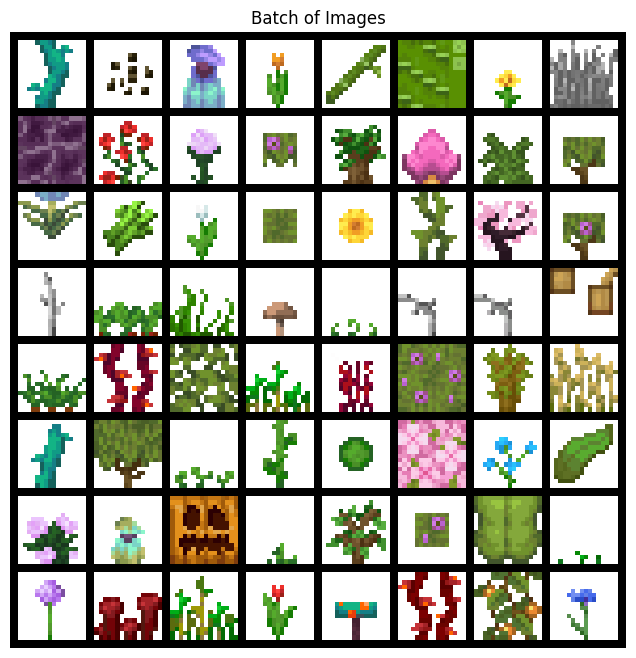

In [31]:
grid = vutils.make_grid(
    images,
    padding=2,
    normalize=True
)

'''
C: channels
H: height
W: width
B: batch size
'''
# CHW -> HWC for matplotlib
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Batch of Images")
plt.imshow(grid.numpy())
plt.show()

### Weights initialization

In [32]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)   
        nn.init.constant_(m.bias.data, 0)

### Generator

In [33]:

# Size of feature maps in generator
ngf = 32

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.gen = nn.Sequential(
            # LAYER 1: The "Foundation" Layer
            # Input: (z_dim) x 1 x 1
            # Output: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(
                in_channels = z_dim,
                out_channels = ngf * 8,
                kernel_size = 4,
                stride = 1,
                padding = 0,
                bias = False
            ),
            nn.BatchNorm2d(num_features = ngf * 8),
            nn.ReLU(inplace = True),
            
            # LAYER 2: First Upsample
            # Input: (ngf * 8) x 4 x 4
            # Output: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(
                in_channels = ngf * 8,
                out_channels = ngf * 4,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(num_features = ngf * 4),
            nn.ReLU(inplace = True),
            
            # LAYER 3: Final Upsample to 16x16 Sprite
            # Input: (ngf * 4) x 8 x 8
            # Output: (nc) x 16 x 16
            nn.ConvTranspose2d(
                in_channels = ngf * 4,
                out_channels = nc,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.gen(x)


In [34]:
'''
import torch.nn as nn
ngf = 32
class Generator(nn.Module):
    def __init__(self, ngpu, z_dim=64, ngf=32, nc=3):
        super().__init__()
        self.ngpu = ngpu

        self.gen = nn.Sequential(
            # z: (z_dim) x 1 x 1 -> (ngf*8) x 4 x 4
            nn.ConvTranspose2d(z_dim, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # 4x4 -> 8x8 (Upsample + Conv)
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(ngf * 8, ngf * 4, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # 8x8 -> 16x16 (Upsample + Conv)
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(ngf * 4, nc, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)
'''

'\nimport torch.nn as nn\nngf = 32\nclass Generator(nn.Module):\n    def __init__(self, ngpu, z_dim=64, ngf=32, nc=3):\n        super().__init__()\n        self.ngpu = ngpu\n\n        self.gen = nn.Sequential(\n            # z: (z_dim) x 1 x 1 -> (ngf*8) x 4 x 4\n            nn.ConvTranspose2d(z_dim, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),\n            nn.BatchNorm2d(ngf * 8),\n            nn.ReLU(True),\n\n            # 4x4 -> 8x8 (Upsample + Conv)\n            nn.Upsample(scale_factor=2, mode="nearest"),\n            nn.Conv2d(ngf * 8, ngf * 4, kernel_size=3, stride=1, padding=1, bias=False),\n            nn.BatchNorm2d(ngf * 4),\n            nn.ReLU(True),\n\n            # 8x8 -> 16x16 (Upsample + Conv)\n            nn.Upsample(scale_factor=2, mode="nearest"),\n            nn.Conv2d(ngf * 4, nc, kernel_size=3, stride=1, padding=1, bias=False),\n            nn.Tanh()\n        )\n\n    def forward(self, x):\n        return self.gen(x)\n'

In [35]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


### Discriminator

In [36]:
# Size of feature maps in discriminator
ndf = 32

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            
            # --- LAYER 1: THE INPUT LAYER ---
            # Input: (nc) x 16 x 16
            # Output: (ndf) x 8 x 8
            nn.Conv2d(
                in_channels  = nc,
                out_channels = ndf,
                kernel_size  = 4,
                stride       = 2, # Halves the dimension
                padding      = 1,
                bias         = False
            ),
            # Note: No BatchNorm in the first layer of the Discriminator (DCGAN rule)
            nn.LeakyReLU(0.2, inplace=True),

            # --- LAYER 2: THE COMPRESSION LAYER ---
            # Input: (ndf) x 8 x 8
            # Output: (ndf * 2) x 4 x 4
            nn.Conv2d(
                in_channels  = ndf,
                out_channels = ndf * 2,
                kernel_size  = 4,
                stride       = 2, # Halves the dimension
                padding      = 1,
                bias         = False
            ),
            nn.BatchNorm2d(num_features = ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # --- LAYER 3: THE CLASSIFICATION LAYER ---
            # Input: (ndf * 2) x 4 x 4
            # Output: 1 x 1 x 1 (A single probability score)
            nn.Conv2d(
                in_channels  = ndf * 2,
                out_channels = 1,
                kernel_size  = 4,
                stride       = 1, # No more downsampling
                padding      = 0,
                bias         = False
            ),
            nn.Sigmoid() # Outputs a value between 0 (Fake) and 1 (Real)
        )

    def forward(self, x):
        return self.disc(x)

In [37]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): Sigmoid()
  )
)


### Loss Function and Optimizers

In [38]:
# Learning rate for optimizers
lrD = 1e-4
lrG = 2e-4

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
beta2 = 0.999

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, beta2))

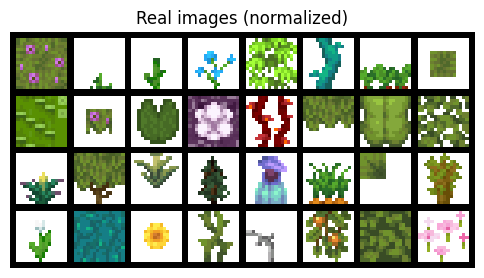

In [39]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

real_images, _ = next(iter(loader))   # unpack (images, labels)
grid = vutils.make_grid(real_images[:32], normalize=True, padding=2)


plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Real images (normalized)")
plt.imshow(np.transpose(grid.cpu(), (1,2,0)))
plt.show()


In [40]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/20][0/3]	Loss_D: 1.4283	Loss_G: 0.6360	D(x): 0.5643	D(G(z)): 0.5622 / 0.5356
[1/20][0/3]	Loss_D: 2.0272	Loss_G: 0.3042	D(x): 0.5979	D(G(z)): 0.7695 / 0.7409
[2/20][0/3]	Loss_D: 2.1839	Loss_G: 0.2555	D(x): 0.6194	D(G(z)): 0.8095 / 0.7766
[3/20][0/3]	Loss_D: 2.1319	Loss_G: 0.2725	D(x): 0.6216	D(G(z)): 0.8009 / 0.7634
[4/20][0/3]	Loss_D: 2.0668	Loss_G: 0.2831	D(x): 0.6380	D(G(z)): 0.7951 / 0.7547
[5/20][0/3]	Loss_D: 2.0261	Loss_G: 0.2883	D(x): 0.6593	D(G(z)): 0.7926 / 0.7515
[6/20][0/3]	Loss_D: 2.0176	Loss_G: 0.2935	D(x): 0.6675	D(G(z)): 0.7910 / 0.7486
[7/20][0/3]	Loss_D: 2.0176	Loss_G: 0.2934	D(x): 0.6592	D(G(z)): 0.7910 / 0.7476
[8/20][0/3]	Loss_D: 1.9594	Loss_G: 0.3074	D(x): 0.6744	D(G(z)): 0.7825 / 0.7378
[9/20][0/3]	Loss_D: 1.9259	Loss_G: 0.3236	D(x): 0.6632	D(G(z)): 0.7740 / 0.7252
[10/20][0/3]	Loss_D: 1.9259	Loss_G: 0.3342	D(x): 0.6507	D(G(z)): 0.7690 / 0.7176
[11/20][0/3]	Loss_D: 1.9277	Loss_G: 0.3383	D(x): 0.6493	D(G(z)): 0.7688 / 0.7146
[12/20][0/3]

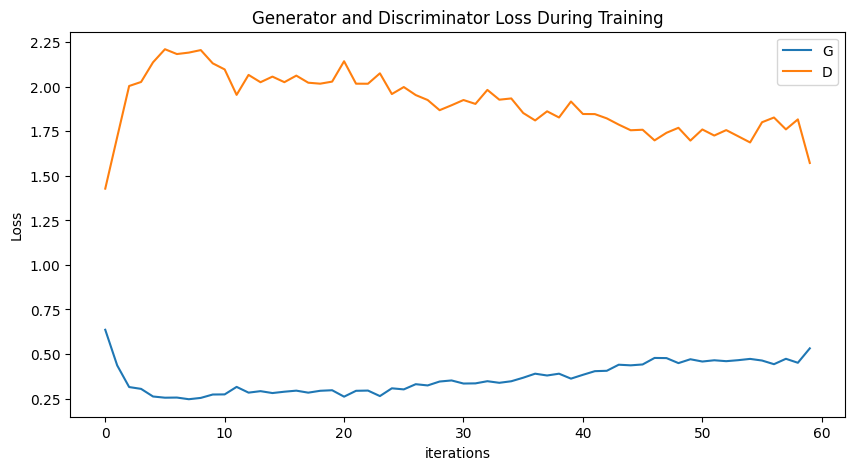

In [41]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

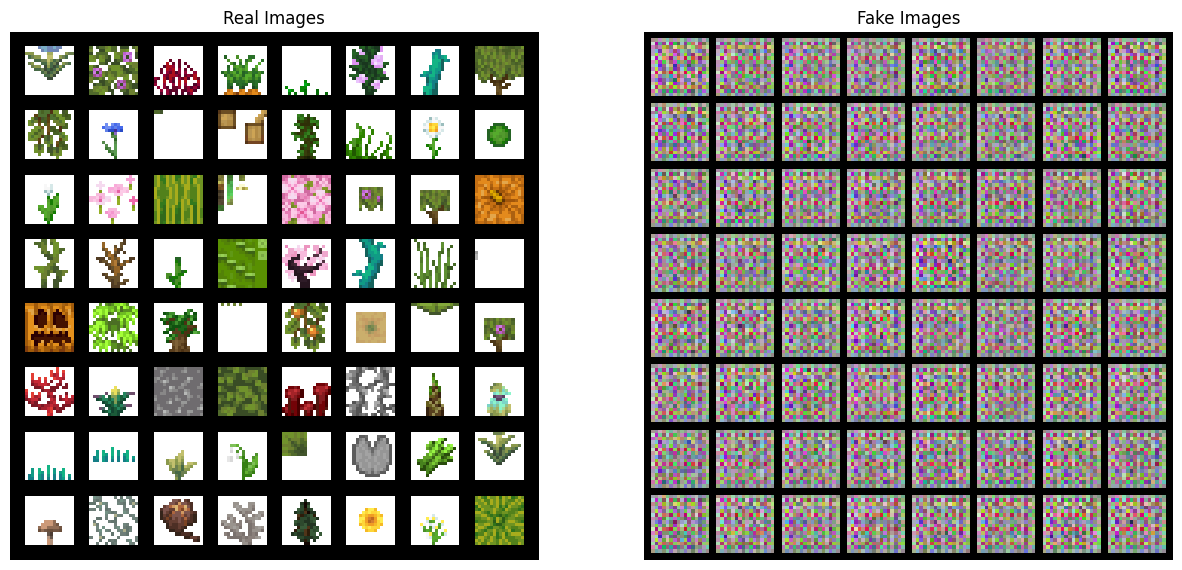

In [42]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

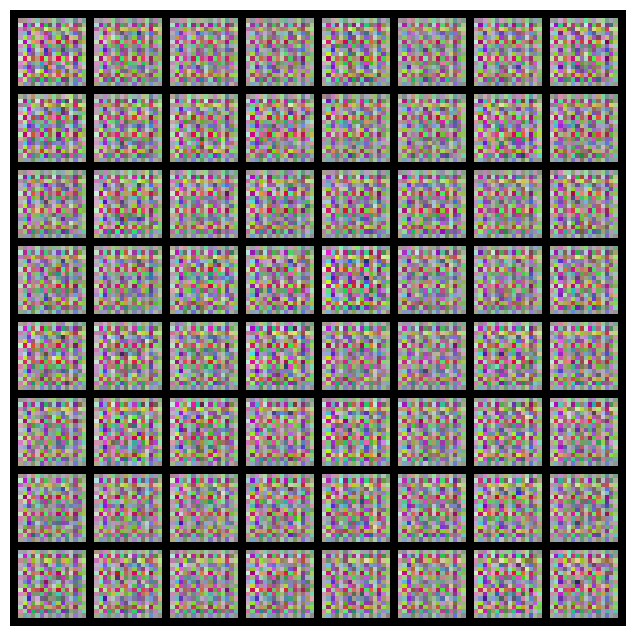

In [43]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

EVALUATION

In [44]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.utils as vutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import kagglehub
import os

In [45]:
import numpy as np, os, torch
import kagglehub
from torch.utils.data import TensorDataset, DataLoader

# 1) Download
path = kagglehub.dataset_download("ebrahimelgazar/pixel-art")
print("Path:", path)

labels_path = os.path.join(path, "sprites_labels.npy")
data_path   = os.path.join(path, "sprites.npy")

# 2) Load numpy
labels = np.load(labels_path)
data   = np.load(data_path)

print("Raw data:", data.shape, data.dtype)
print("Raw labels:", labels.shape, labels.dtype)

# 3) To torch
images_tensor = torch.tensor(data, dtype=torch.float32)     # [0..255]
labels_tensor = torch.tensor(labels, dtype=torch.float32)   # one-hot likely

# 4) HWC -> CHW
images_tensor = images_tensor.permute(0, 3, 1, 2)           # (N,C,H,W)
print("After permute:", images_tensor.shape)

# 5) Normalize to [-1, 1]
images_tensor = images_tensor / 255.0
images_tensor = (images_tensor - 0.5) / 0.5
print("After normalize min/max:", images_tensor.min().item(), images_tensor.max().item())

# 6) One-hot -> class id
if labels_tensor.ndim > 1:
    labels_tensor = labels_tensor.argmax(dim=1).long()
print("Labels:", labels_tensor.shape, labels_tensor.dtype, "unique:", torch.unique(labels_tensor))

# 7) Dataset + loader
dataset = TensorDataset(images_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Device:", device)
print("Dataset size:", len(dataset))


Path: C:\Users\User\.cache\kagglehub\datasets\ebrahimelgazar\pixel-art\versions\1
Raw data: (89400, 16, 16, 3) uint8
Raw labels: (89400, 5) float64
After permute: torch.Size([89400, 3, 16, 16])
After normalize min/max: -1.0 1.0
Labels: torch.Size([89400]) torch.int64 unique: tensor([0, 1, 2, 3, 4])
Device: cuda:0
Dataset size: 89400


In [46]:
imgs_real, y = next(iter(loader))
print(imgs_real.shape, imgs_real.min().item(), imgs_real.max().item())


torch.Size([64, 3, 16, 16]) -1.0 1.0


In [47]:
torch.manual_seed(42)

N = len(dataset)
n_train = int(0.8 * N)
n_test  = N - n_train

eval_train_set, eval_test_set = random_split(dataset, [n_train, n_test])


eval_train_loader = DataLoader(eval_train_set, batch_size=batch_size, shuffle=True,  num_workers=workers, pin_memory=True)
eval_test_loader  = DataLoader(eval_test_set,  batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

print("Train/Test:", len(eval_train_set), len(eval_test_set))
print("Train/Test:", (len(eval_train_set)/(len(eval_train_set)+len(eval_test_set))), (len(eval_test_loader))/(len(eval_test_loader)+len(eval_train_loader)))


Train/Test: 71520 17880
Train/Test: 0.8 0.20028612303290416


In [48]:
torch.manual_seed(42)
g = torch.Generator().manual_seed(42)

N = len(dataset)
n_train = int(0.8 * N)
n_test  = N - n_train

eval_train_set, eval_test_set = random_split(dataset, [n_train, n_test], generator=g)

eval_train_loader = DataLoader(eval_train_set, batch_size=batch_size, shuffle=True,  num_workers=workers, pin_memory=True)
eval_test_loader  = DataLoader(eval_test_set,  batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

print("Train/Test:", len(eval_train_set), len(eval_test_set))
print("Ratio:", len(eval_train_set)/N, len(eval_test_set)/N)

Train/Test: 71520 17880
Ratio: 0.8 0.2


In [49]:
netD.eval()
for p in netD.parameters():
    p.requires_grad = False

@torch.no_grad()
def get_scores_real(loader):
    scores, labels = [], []
    for imgs, y in loader:
        imgs = imgs.to(device)

        s = netD(imgs)
        s = s.view(s.size(0), -1).mean(dim=1)  # (N,)
        scores.append(s.cpu().numpy())
        labels.append(y.cpu().numpy())
    return np.concatenate(scores), np.concatenate(labels)

@torch.no_grad()
def get_scores_fake(netG, n_samples, batch_size=128, nz=64):
    scores = []
    netG.eval()
    for i in range(0, n_samples, batch_size):
        cur = min(batch_size, n_samples - i)
        z = torch.randn(cur, nz, 1, 1, device=device)
        fake = netG(z)
        s = netD(fake)
        s = s.view(s.size(0), -1).mean(dim=1)
        scores.append(s.cpu().numpy())
    return np.concatenate(scores)

real_scores, real_labels = get_scores_real(eval_test_loader)
fake_scores = get_scores_fake(netG, n_samples=len(real_scores), batch_size=batch_size, nz=64)

print(real_scores.shape, fake_scores.shape)
print("Real mean/std:", real_scores.mean(), real_scores.std())
print("Fake mean/std:", fake_scores.mean(), fake_scores.std())


RuntimeError: Given transposed=1, weight of size [100, 256, 4, 4], expected input[64, 64, 1, 1] to have 100 channels, but got 64 channels instead

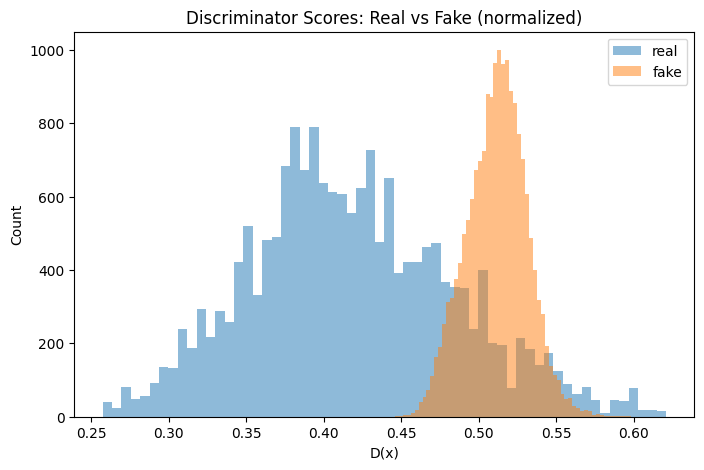

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(real_scores, bins=60, alpha=0.5, label="real")
plt.hist(fake_scores, bins=60, alpha=0.5, label="fake")
plt.title("Discriminator Scores: Real vs Fake (normalized)")
plt.xlabel("D(x)")
plt.ylabel("Count")
plt.legend()
plt.show()


In [ ]:
def cohens_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    na, nb = len(a), len(b)
    sa, sb = a.var(ddof=1), b.var(ddof=1)
    s = np.sqrt(((na-1)*sa + (nb-1)*sb) / (na+nb-2))
    return (a.mean() - b.mean()) / (s + 1e-12)

print("Real mean/std:", real_scores.mean(), real_scores.std())
print("Fake mean/std:", fake_scores.mean(), fake_scores.std())
print("Cohen's d (real - fake):", cohens_d(real_scores, fake_scores))


Real mean/std: 0.41841477 0.06664003
Fake mean/std: 0.51153743 0.019294512
Cohen's d (real - fake): -1.8982025


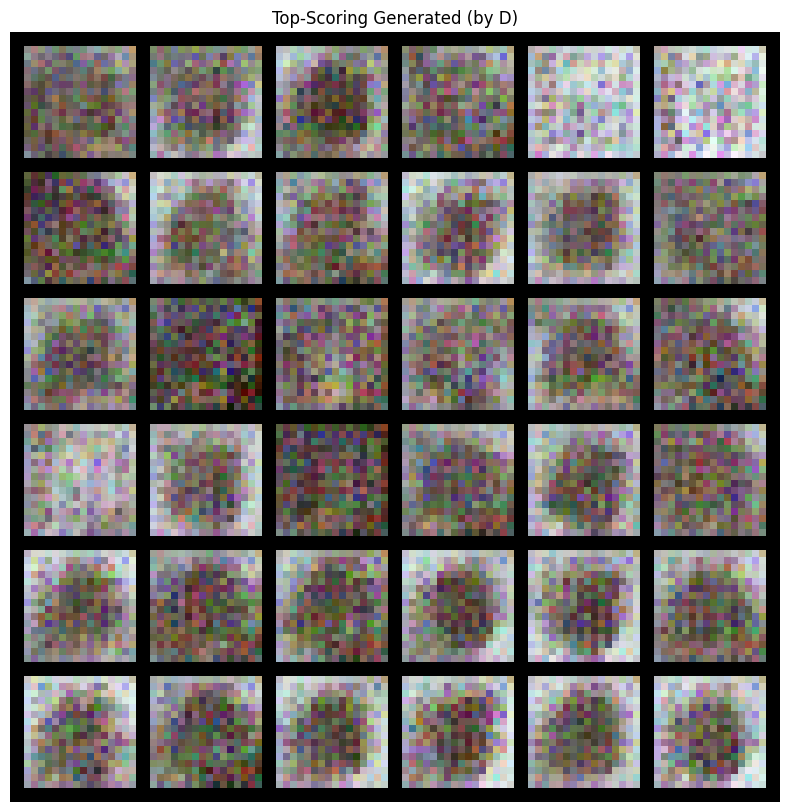

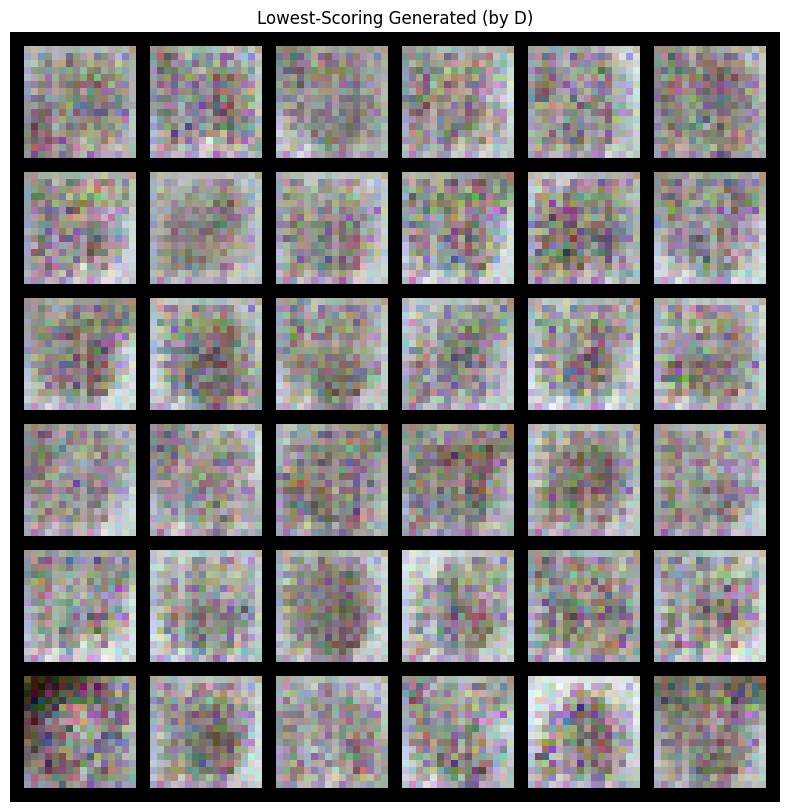

Best score range: 0.53601867 to 0.578229
Worst score range: 0.458451 to 0.48548713


In [ ]:
@torch.no_grad()
def sample_fake_with_scores(netG, n=512, nz=64):
    z = torch.randn(n, nz, 1, 1, device=device)
    fake = netG(z)
    s = netD(fake).view(n, -1).mean(dim=1).cpu().numpy()
    return fake.cpu(), s

fake_imgs, fake_s = sample_fake_with_scores(netG, n=512, nz=64)

best_idx  = np.argsort(fake_s)[-36:]
worst_idx = np.argsort(fake_s)[:36]

grid_best  = vutils.make_grid(fake_imgs[best_idx],  nrow=6, normalize=True)
grid_worst = vutils.make_grid(fake_imgs[worst_idx], nrow=6, normalize=True)

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid_best.numpy(), (1,2,0)))
plt.axis("off")
plt.title("Top-Scoring Generated (by D)")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid_worst.numpy(), (1,2,0)))
plt.axis("off")
plt.title("Lowest-Scoring Generated (by D)")
plt.show()

print("Best score range:", fake_s[best_idx].min(), "to", fake_s[best_idx].max())
print("Worst score range:", fake_s[worst_idx].min(), "to", fake_s[worst_idx].max())
